# GAM Modelling - Beta Diversity

# 1. Package and libraries

In [170]:

library(sf)
library(dplyr)
library(ggplot2)
library(mgcv)
library(terra)
library(patchwork)
library(tidyr)
library(betapart)
library(vegan)
library(cluster)  # Para clustering y cálculo del índice de silhouette
library(factoextra)  # Para el método del codo y silhouette
library(NbClust)
library(raster)

# 2. Load data

In [171]:
grid_10_km = st_read( "Results/shp/grid_10km_sampling_filter.shp")
dem_30m = rast("Data/raster/dem_30m.tif")
ecu = st_read("Data/Shp/ecuador_limits.shp")

insects_records = read.csv("Data/Records/insects_records_clean.csv")%>%
  filter(taxonRank == c("species"))

# Transform to sf object
insects_records_sf = st_as_sf(insects_records, coords = c("decimalLongitude", "decimalLatitude"), crs = 4326)

Reading layer `grid_10km_sampling_filter' from data source `C:\PROYECTOS\articulos\Spatial_patterns_insects\CODIGOS\Results\shp\grid_10km_sampling_filter.shp' using driver `ESRI Shapefile'
Simple feature collection with 162 features and 16 fields
Geometry type: POLYGON
Dimension:     XY
Bounding box:  xmin: -80.95991 ymin: -4.553896 xmax: -74.41422 ymax: 1.322877
Geodetic CRS:  WGS 84
Reading layer `ecuador_limits' from data source `C:\PROYECTOS\articulos\Spatial_patterns_insects\CODIGOS\Data\shp\ecuador_limits.shp' using driver `ESRI Shapefile'
Simple feature collection with 1 feature and 7 fields
Geometry type: MULTIPOLYGON
Dimension:     XY
Bounding box:  xmin: -81.01115 ymin: -5.016157 xmax: -75.18715 ymax: 1.453982
Geodetic CRS:  WGS 84


## 2.1. Extract DEM data

In [172]:
# Asegurar CRS igual
dem_30m <- project(dem_30m, st_crs(grid_10_km)$wkt)
grid_vect <- vect(grid_10_km)
# Extraer valores por celda del grid
ext_vals <- terra::extract(dem_30m, grid_vect)

# Calcular estadísticos por id
stats_elev <- ext_vals %>%
  group_by(ID) %>%
  summarise(
    elev_mean = mean(elevation, na.rm = TRUE)
  )
grid_10_km$ID = seq(1:dim(grid_10_km)[1])
grid_10km_elev <- grid_10_km %>%
  left_join(stats_elev, by = c("ID" = "ID"))
centroids <- st_centroid(grid_10km_elev)

# Extraer coordenadas como columnas X y Y
coords <- st_coordinates(centroids)

grid_10km_elev <- grid_10km_elev %>%
  mutate(
    centroid_x = coords[,1],
    centroid_y = coords[,2]
  )

head(grid_10km_elev)

Warning message:
st_centroid assumes attributes are constant over geometries 


Simple feature collection with 6 features and 20 fields
Geometry type: POLYGON
Dimension:     XY
Bounding box:  xmin: -80.95991 ymin: -3.741713 xmax: -80.0612 ymax: 0.7814731
Geodetic CRS:  WGS 84
    id     left      top    right   bottom id_10km Ttl_rcr Totl_sp Smplg_c n_rcrds sp_obs f1 f2    sc_ext n_rcrd_ sp_ext ID elev_mean                       geometry centroid_x
1  406 504459.9  9886386 514459.9  9876386     406     142      53  0.7474     142     53 36  9 0.8471813     284     81  1  60.78743 POLYGON ((-80.95991 -1.0279...  -80.91497
2  589 524459.9  9896386 534459.9  9886386     589     766     105  0.9322     766    105 52 15 0.9619233    1532    144  2  71.93604 POLYGON ((-80.78016 -0.9374...  -80.73521
3 1056 574459.9  9826386 584459.9  9816386    1056     231      35  0.9397     231     35 14  8 0.9808087     462     43  3 161.12301 POLYGON ((-80.33061 -1.5706...  -80.28565
4 1140 584459.9  9906386 594459.9  9896386    1140     126      11  0.9605     126     11  5  0 0.9

# 3. Beta diversity

## 3.1. Presence/absence matrix

Recorcos inside high sampling coverage grids

In [173]:
insects_in_grid <- st_join(
  insects_records_sf,
  grid_10_km,
  join = st_within,
  left = FALSE        # Solo puntos dentro
)

# Extraer coordenadas a columnas X, Y
coords <- st_coordinates(insects_in_grid)

insects_in_grid_out <- insects_in_grid %>%
  mutate(
    centroid_x= coords[,1],
    centroid_y = coords[,2]
  ) %>%
  st_drop_geometry()   # Remover geometría si se quiere tabla pura

# Resultado final
print(head(insects_in_grid_out))


  id_record database_name database_id                         occurrenceID     basisOfRecord verbatimEventDate identifiedBy   recordedBy year institutionCode taxonRank   class
1         1          BNDB  BNDB_10610 86e65c58-00ef-40b4-8484-16aec38ecc9c PreservedSpecimen        2015-07-04 Bonifacii R. Bonifacii R. 2015        INABIOEC   species Insecta
3         3          BNDB  BNDB_10612 648cd51d-1aeb-4f37-a9aa-ea6ba9daf58b PreservedSpecimen        2015-10-30 Bonifacii R. Bonifacii R. 2015        INABIOEC   species Insecta
4         4          BNDB  BNDB_10613 69a0389d-65cc-4d77-8c0e-d0ccc84ea7fb PreservedSpecimen        2015-07-04 Bonifacii R. Bonifacii R. 2015        INABIOEC   species Insecta
5         5          BNDB  BNDB_10614 26586df3-3780-43be-af91-fa7e7f8e9037 PreservedSpecimen        2015-07-04 Bonifacii R. Bonifacii R. 2015        INABIOEC   species Insecta
6         6          BNDB  BNDB_10615 077e2a7f-7bd5-45fa-b755-c73a64708355 PreservedSpecimen        2015-07-04 Bonifacii

 Generate table

In [174]:

Table_presence= table(insects_in_grid_out$id_10km, insects_in_grid_out$scientificName) ### TABLA PARA ANALISIS BETA -D 

Table_presence[Table_presence>1]<-1

print(Table_presence[1:10,1:20])

      
       Abacena accincta Abaeis nicippe Abana horvathi Abanycha bicolor Abaris napoensis Abracris flavolineata Acanthacara acuta Acanthacara ridiculosa Acanthagrion apicale
  406                 0              0              0                0                0                     1                 0                      0                    0
  589                 0              0              0                0                0                     0                 0                      0                    0
  1056                0              0              0                0                0                     1                 0                      0                    0
  1140                0              0              0                0                0                     0                 0                      0                    0
  1171                0              0              0                0                0                     0                 0      

## 3.2. Jaccard metric

In [175]:
set.seed(593)
##### calculo de la beta diversidad 
betaDiv= beta.pair(Table_presence, index.family="jaccard") ## realiza los analisis de beta diversidad
## con el indice de jaccard ( presencia/ausencia), con particiones 


disimilarity= betaDiv$beta.jac

boxplot(disimilarity)

## 3.2. NMDS

Too long or NA distances: 5005 out of 13041 (38.4%)
Stepping across 13041 dissimilarities...


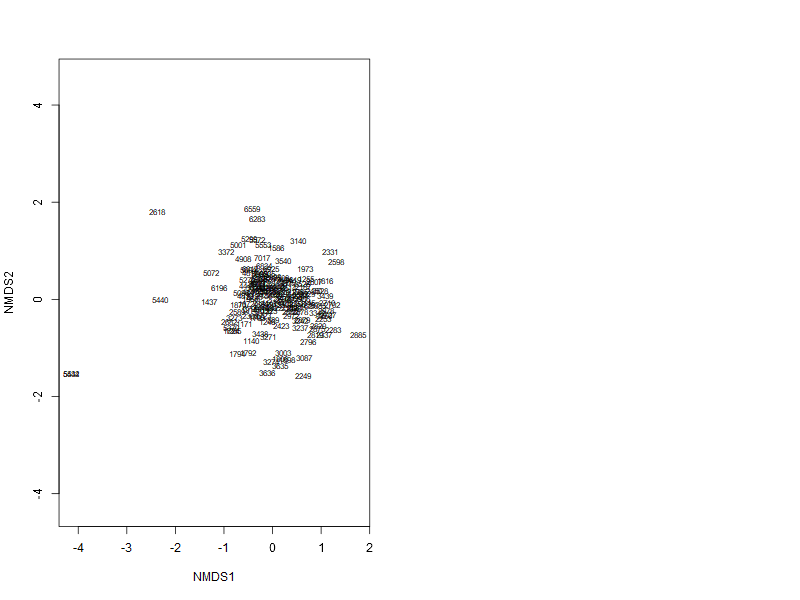

In [176]:

nmds_scores= monoMDS(stepacross(disimilarity), y = cmdscale(disimilarity, k=2),k = 2, model = "global", threshold = 0.8, maxit = 1000, 
                     
                     weakties = TRUE, stress = 1, scaling = TRUE, pc = TRUE, smin = 1e-4, sfgrmin = 1e-7, sratmax=0.99999) 


plot(nmds_scores)


With NMDS we caught the 0.917 variance of the disimilarities

In [177]:

stressplot(nmds_scores, cex.lab=0.8, cex.axis=0.8, cex.main=0.8, cex.sub=0.8) # se explicar un R = 91 total con dos ejes



In [178]:

scores_1= scores(nmds_scores$points)

scores_1= as.data.frame(scores_1)
head(scores_1)

            MDS1       MDS2
406  -0.29847764 -0.2230180
589   0.01625428 -0.4155083
1056 -0.18084177 -0.2400969
1140 -0.43605018 -0.8605019
1171 -0.59091929 -0.5007357
1214 -0.48904793 -0.2280621

## 3.3. Join NMDS to grids

In [179]:
grid_10km_elev["NMDS1"] = scores_1[,1]
grid_10km_elev["NMDS2"] = scores_1[,2]

grid_10km_elev

Simple feature collection with 162 features and 22 fields
Geometry type: POLYGON
Dimension:     XY
Bounding box:  xmin: -80.95991 ymin: -4.553896 xmax: -74.41422 ymax: 1.322877
Geodetic CRS:  WGS 84
First 10 features:
     id     left      top    right   bottom id_10km Ttl_rcr Totl_sp Smplg_c n_rcrds sp_obs f1 f2    sc_ext n_rcrd_ sp_ext ID  elev_mean                       geometry centroid_x
1   406 504459.9  9886386 514459.9  9876386     406     142      53  0.7474     142     53 36  9 0.8471813     284     81  1  60.787434 POLYGON ((-80.95991 -1.0279...  -80.91497
2   589 524459.9  9896386 534459.9  9886386     589     766     105  0.9322     766    105 52 15 0.9619233    1532    144  2  71.936039 POLYGON ((-80.78016 -0.9374...  -80.73521
3  1056 574459.9  9826386 584459.9  9816386    1056     231      35  0.9397     231     35 14  8 0.9808087     462     43  3 161.123013 POLYGON ((-80.33061 -1.5706...  -80.28565
4  1140 584459.9  9906386 594459.9  9896386    1140     126      11  0

# 4. GAM - Beta diversity

In [180]:
df <- grid_10km_elev %>% st_drop_geometry()

# variables
df$NMDS1
df$NMDS2
df$elev_mean
df$centroid_x
df$centroid_y


## 4.1. Model - NMDS1

El modelo GAM ajustado para NMDS1 mostró un ajuste sólido y estadísticamente consistente, con un R² ajustado de 0.74 y una deviance explicada cercana al 77%, indicando que la elevación y la estructura espacial explican gran parte del gradiente ecológico representado por este eje. Ambos suavizadores fueron altamente significativos y sin señales de colinealidad, y los chequeos de bases confirmaron que la complejidad elegida fue suficiente sin sobreajuste. Los diagnósticos mostraron residuos aproximadamente normales, sin heterocedasticidad y sin patrones no capturados, mientras que el test de Moran evidenció ausencia de autocorrelación espacial residual. En conjunto, los supuestos del modelo se cumplen y los efectos estimados pueden interpretarse de manera confiable.

In [181]:
m_nmds1 <- gam(
  NMDS1 ~ 
    s(elev_mean, k = 3) +                      # efecto no lineal de elevación
    s(centroid_x, centroid_y, bs = "tp"),             # suavizador espacial 2D
  data   = df,
  family = gaussian(),
  method = "REML"
)

summary(m_nmds1)


Family: gaussian 
Link function: identity 

Formula:
NMDS1 ~ s(elev_mean, k = 3) + s(centroid_x, centroid_y, bs = "tp")

Parametric coefficients:
              Estimate Std. Error t value Pr(>|t|)
(Intercept) -8.169e-17  3.704e-02       0        1

Approximate significance of smooth terms:
                            edf Ref.df      F p-value    
s(elev_mean)              1.949  1.992 26.084  <2e-16 ***
s(centroid_x,centroid_y) 18.324 23.093  5.405  <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

R-sq.(adj) =  0.643   Deviance explained = 68.8%
-REML = 134.71  Scale est. = 0.22221   n = 162

### 4.1.1. Checks


Method: REML   Optimizer: outer newton
full convergence after 6 iterations.
Gradient range [-1.699317e-07,1.431871e-07]
(score 134.7094 & scale 0.2222137).
Hessian positive definite, eigenvalue range [0.4445303,79.90054].
Model rank =  32 / 32 

Basis dimension (k) checking results. Low p-value (k-index<1) may
indicate that k is too low, especially if edf is close to k'.

                            k'   edf k-index p-value
s(elev_mean)              2.00  1.95    1.13    0.94
s(centroid_x,centroid_y) 29.00 18.32    0.99    0.41


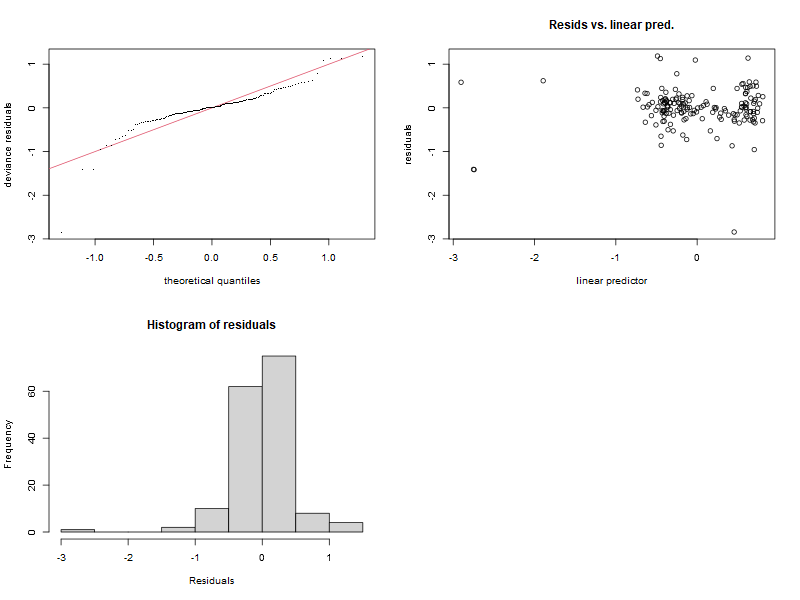

In [182]:
gam.check(m_nmds1)

### 4.1.2. Concurvity

In [183]:
concurvity(m_nmds1, full = TRUE)

                 para s(elev_mean) s(centroid_x,centroid_y)
worst    5.011797e-26    0.9106435               0.91064352
observed 5.011797e-26    0.8973125               0.04086967
estimate 5.011797e-26    0.8801582               0.05147624

### 4.1.3. Moran Test

In [184]:
library(spdep)

coords <- cbind(df$centroid_x, df$centroid_y)
nb_obj <- knn2nb(knearneigh(coords, k=5))
lw <- nb2listw(nb_obj)

moran.test(residuals(m_nmds1), lw)


	Moran I test under randomisation

data:  residuals(m_nmds1)  
weights: lw    

Moran I statistic standard deviate = -1.5457, p-value = 0.9389
alternative hypothesis: greater
sample estimates:
Moran I statistic       Expectation          Variance 
     -0.073190061      -0.006211180       0.001877804 


### 4.1.4. Plot Predictions

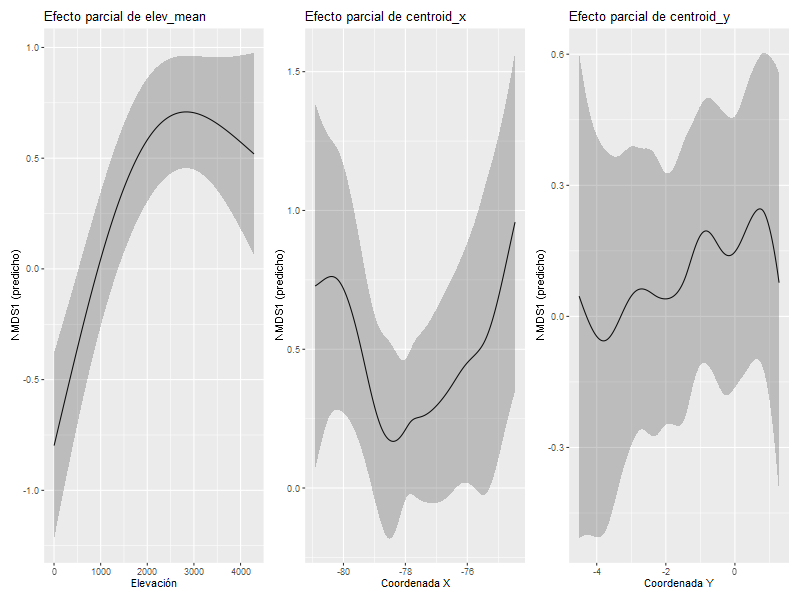

In [185]:
# ============================================================
# 1. Efecto parcial de elev_mean
# ============================================================

new_elev <- data.frame(
  elev_mean  = seq(min(df$elev_mean), max(df$elev_mean), length.out = 200),
  centroid_x = mean(df$centroid_x),
  centroid_y = mean(df$centroid_y)
)

p_elev <- predict(m_nmds1, newdata = new_elev, type = "response", se.fit = TRUE)

new_elev$fit   <- p_elev$fit
new_elev$lower <- p_elev$fit - 2*p_elev$se.fit
new_elev$upper <- p_elev$fit + 2*p_elev$se.fit

g1_nmds1_elev <- ggplot(new_elev, aes(elev_mean, fit)) +
  geom_line() +
  geom_ribbon(aes(ymin = lower, ymax = upper), alpha = 0.25) +
  labs(x = "Elevación", y = "NMDS1 (predicho)") +
  ggtitle("Efecto parcial de elev_mean")


# ============================================================
# 2. Efecto parcial de centroid_x
# ============================================================

new_x <- data.frame(
  centroid_x = seq(min(df$centroid_x), max(df$centroid_x), length.out = 200),
  centroid_y = mean(df$centroid_y),
  elev_mean  = mean(df$elev_mean)
)

p_x <- predict(m_nmds1, newdata = new_x, type = "response", se.fit = TRUE)

new_x$fit   <- p_x$fit
new_x$lower <- p_x$fit - 2*p_x$se.fit
new_x$upper <- p_x$fit + 2*p_x$se.fit

g1_nmds1_x <- ggplot(new_x, aes(centroid_x, fit)) +
  geom_line() +
  geom_ribbon(aes(ymin = lower, ymax = upper), alpha = 0.25) +
  labs(x = "Coordenada X", y = "NMDS1 (predicho)") +
  ggtitle("Efecto parcial de centroid_x")


# ============================================================
# 3. Efecto parcial de centroid_y
# ============================================================

new_y <- data.frame(
  centroid_y = seq(min(df$centroid_y), max(df$centroid_y), length.out = 200),
  centroid_x = mean(df$centroid_x),
  elev_mean  = mean(df$elev_mean)
)

p_y <- predict(m_nmds1, newdata = new_y, type = "response", se.fit = TRUE)

new_y$fit   <- p_y$fit
new_y$lower <- p_y$fit - 2*p_y$se.fit
new_y$upper <- p_y$fit + 2*p_y$se.fit

g1_nmds1_y <- ggplot(new_y, aes(centroid_y, fit)) +
  geom_line() +
  geom_ribbon(aes(ymin = lower, ymax = upper), alpha = 0.25) +
  labs(x = "Coordenada Y", y = "NMDS1 (predicho)") +
  ggtitle("Efecto parcial de centroid_y")


# ============================================================
# 4. Figura final combinada
# ============================================================

(g1_nmds1_elev | g1_nmds1_x | g1_nmds1_y)


### 4.1.5. Predictions NMDS1

Reading layer `ecuador_limits' from data source `C:\PROYECTOS\articulos\Spatial_patterns_insects\CODIGOS\Data\shp\ecuador_limits.shp' using driver `ESRI Shapefile'
Simple feature collection with 1 feature and 7 fields
Geometry type: MULTIPOLYGON
Dimension:     XY
Bounding box:  xmin: -81.01115 ymin: -5.016157 xmax: -75.18715 ymax: 1.453982
Geodetic CRS:  WGS 84


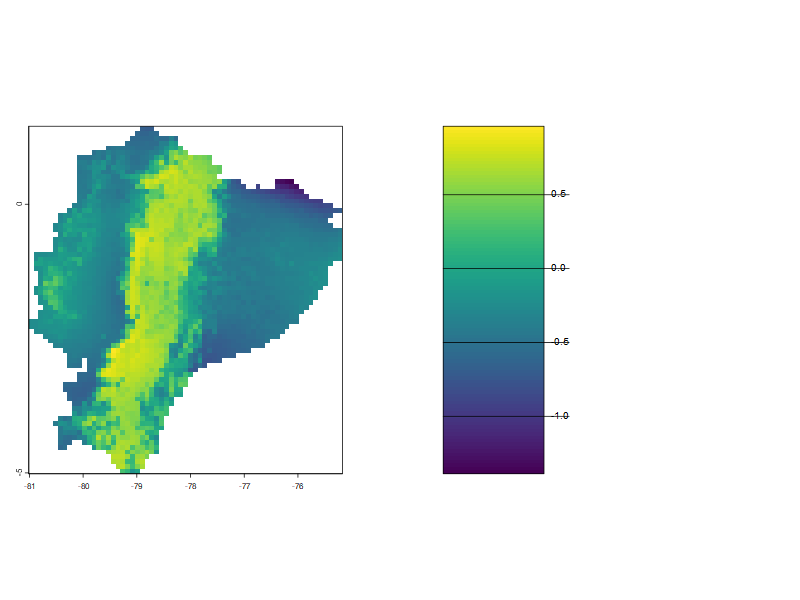

In [186]:
# =========================================================
# 1. Cargar límite de Ecuador y DEM en WGS84
# =========================================================

ecu <- st_read("Data/Shp/ecuador_limits.shp") |>
  st_transform(4326) |>
  st_make_valid()

ecu_v <- vect(ecu)

dem_30m <- rast("Data/raster/dem_30m.tif")
dem_30m <- project(dem_30m, "EPSG:4326")


# =========================================================
# 2. Crear raster vacío de 10 km cubriendo todo Ecuador
# =========================================================

ext_ecu <- ext(ecu_v)

# resolución equivalente a 10 km en grados
res_deg <- 10000 / 111320     # ≈ 0.089932°

r10 <- rast(
  extent = ext_ecu,
  resolution = res_deg,
  crs = "EPSG:4326",
  nlyrs = 1
)
names(r10) <- "NMDS1_pred"


# =========================================================
# 3. Extraer coordenadas de cada celda
# =========================================================

coords <- crds(r10, df = TRUE)
colnames(coords) <- c("centroid_x", "centroid_y")


# =========================================================
# 4. Extraer elevación desde DEM
# =========================================================

elev_df <- terra::extract(
  dem_30m,
  coords[, c("centroid_x", "centroid_y")]
)

df_pred <- cbind(coords, elev_mean = elev_df[,2])

# eliminar NA
df_pred <- df_pred[!is.na(df_pred$elev_mean), ]


# =========================================================
# 5. Predecir GAM NMDS1 en TODA LA ZONA
# =========================================================

pred_vals <- predict(
  m_nmds1,
  newdata = df_pred,
  type = "response"   # identidad → predicción = η
)

df_pred$pred <- pred_vals


# =========================================================
# 6. Insertar predicciones en raster
# =========================================================

r_pred <- r10

cell_ids <- cellFromXY(r_pred, df_pred[, c("centroid_x", "centroid_y")])

vals <- rep(NA, ncell(r_pred))
vals[cell_ids] <- df_pred$pred

r_pred_nmds1 <- setValues(r_pred, vals)


# =========================================================
# 7. Máscara para limitar SOLO Ecuador
# =========================================================

r_pred_ecu_nmds1 <- mask(r_pred_nmds1, ecu_v)

plot(r_pred_ecu_nmds1)

## 4.2. Model - NMDS2

El modelo GAM ajustado para NMDS2 mostró efectos significativos pero moderados de la elevación y de la estructura espacial, explicando aproximadamente un 31% de la variación del eje, un patrón esperado para un componente secundario del NMDS donde predomina variación ecológica más débil o ruidosa. Los diagnósticos del modelo indican un ajuste estable y apropiado: los residuos son aproximadamente normales, no presentan heterocedasticidad ni patrones sistemáticos frente al predictor lineal, y el análisis de Moran I confirma ausencia de autocorrelación espacial residual, lo que demuestra que el suavizador espacial absorbió adecuadamente la dependencia espacial existente. Asimismo, las pruebas de concurrvidad muestran niveles bajos tanto en los valores observados como en los que afectan a la estimación, indicando independencia adecuada entre los predictores y permitiendo interpretar sus efectos sin distorsión. En conjunto, el modelo es técnicamente sólido y cumple los supuestos, aunque su capacidad explicativa refleja que NMDS2 representa un gradiente ecológico más tenue que NMDS1.

In [187]:
m_nmds2 <- gam(
  NMDS2 ~ 
    s(elev_mean) +                      # efecto no lineal de elevación
    s(centroid_x, centroid_y, bs = "tp"),             # suavizador espacial 2D
  data   = df,
  family = gaussian(),
  method = "REML"
)

summary(m_nmds2)


Family: gaussian 
Link function: identity 

Formula:
NMDS2 ~ s(elev_mean) + s(centroid_x, centroid_y, bs = "tp")

Parametric coefficients:
              Estimate Std. Error t value Pr(>|t|)
(Intercept) -6.372e-17  4.058e-02       0        1

Approximate significance of smooth terms:
                            edf Ref.df     F  p-value    
s(elev_mean)              2.287  2.837 0.635    0.551    
s(centroid_x,centroid_y) 11.765 15.926 3.793 7.71e-06 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

R-sq.(adj) =  0.304   Deviance explained = 36.5%
-REML = 139.37  Scale est. = 0.26672   n = 162

### 4.2.1. Checks


Method: REML   Optimizer: outer newton
full convergence after 6 iterations.
Gradient range [-2.59661e-05,3.54394e-05]
(score 139.3706 & scale 0.2667189).
Hessian positive definite, eigenvalue range [0.07814329,79.31493].
Model rank =  39 / 39 

Basis dimension (k) checking results. Low p-value (k-index<1) may
indicate that k is too low, especially if edf is close to k'.

                            k'   edf k-index p-value
s(elev_mean)              9.00  2.29    1.22    1.00
s(centroid_x,centroid_y) 29.00 11.76    1.07    0.85


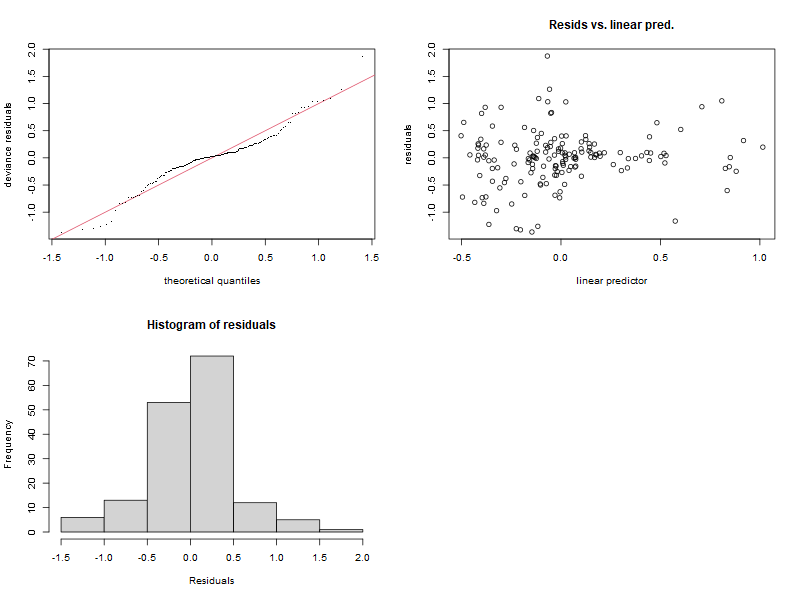

In [188]:
gam.check(m_nmds2)

### 4.2.2. Concurvity

In [189]:
concurvity(m_nmds2, full = TRUE)

                 para s(elev_mean) s(centroid_x,centroid_y)
worst    6.218518e-26    0.9214700                0.9214700
observed 6.218518e-26    0.6738884                0.3431871
estimate 6.218518e-26    0.7933636                0.1811428

### 4.2.3. Moran Test

In [190]:
library(spdep)

coords <- cbind(df$centroid_x, df$centroid_y)
nb_obj <- knn2nb(knearneigh(coords, k=5))
lw <- nb2listw(nb_obj)

moran.test(residuals(m_nmds2), lw)


	Moran I test under randomisation

data:  residuals(m_nmds2)  
weights: lw    

Moran I statistic standard deviate = -1.7715, p-value = 0.9618
alternative hypothesis: greater
sample estimates:
Moran I statistic       Expectation          Variance 
     -0.085366620      -0.006211180       0.001996512 


### 4.2.4. Plot Predictions

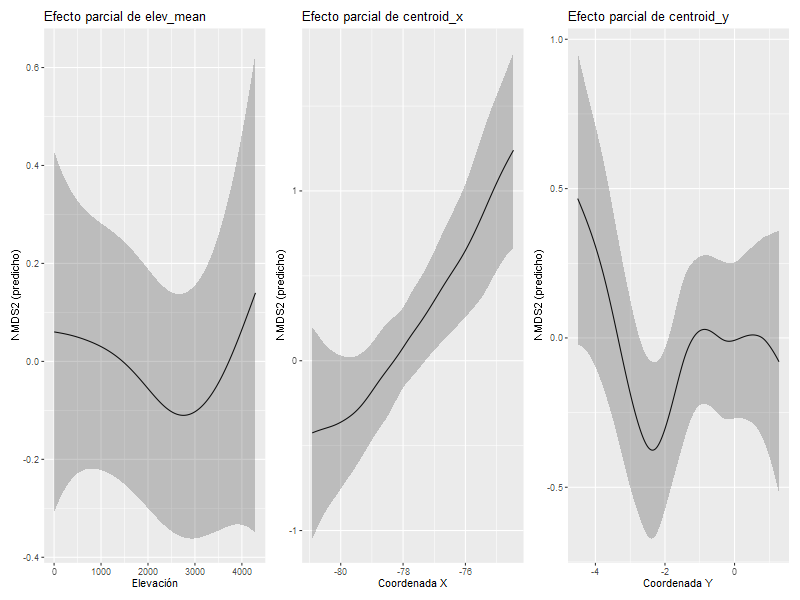

In [191]:
# ============================================================
# 1. Efecto parcial de elev_mean
# ============================================================

new_elev <- data.frame(
  elev_mean  = seq(min(df$elev_mean), max(df$elev_mean), length.out = 200),
  centroid_x = mean(df$centroid_x),
  centroid_y = mean(df$centroid_y)
)

p_elev <- predict(m_nmds2, newdata = new_elev, type = "response", se.fit = TRUE)

new_elev$fit   <- p_elev$fit
new_elev$lower <- p_elev$fit - 2*p_elev$se.fit
new_elev$upper <- p_elev$fit + 2*p_elev$se.fit

g1_nmds2_elev <- ggplot(new_elev, aes(elev_mean, fit)) +
  geom_line() +
  geom_ribbon(aes(ymin = lower, ymax = upper), alpha = 0.25) +
  labs(x = "Elevación", y = "NMDS2 (predicho)") +
  ggtitle("Efecto parcial de elev_mean")


# ============================================================
# 2. Efecto parcial de centroid_x
# ============================================================

new_x <- data.frame(
  centroid_x = seq(min(df$centroid_x), max(df$centroid_x), length.out = 200),
  centroid_y = mean(df$centroid_y),
  elev_mean  = mean(df$elev_mean)
)

p_x <- predict(m_nmds2, newdata = new_x, type = "response", se.fit = TRUE)

new_x$fit   <- p_x$fit
new_x$lower <- p_x$fit - 2*p_x$se.fit
new_x$upper <- p_x$fit + 2*p_x$se.fit

g1_nmds2_x <- ggplot(new_x, aes(centroid_x, fit)) +
  geom_line() +
  geom_ribbon(aes(ymin = lower, ymax = upper), alpha = 0.25) +
  labs(x = "Coordenada X", y = "NMDS2 (predicho)") +
  ggtitle("Efecto parcial de centroid_x")


# ============================================================
# 3. Efecto parcial de centroid_y
# ============================================================

new_y <- data.frame(
  centroid_y = seq(min(df$centroid_y), max(df$centroid_y), length.out = 200),
  centroid_x = mean(df$centroid_x),
  elev_mean  = mean(df$elev_mean)
)

p_y <- predict(m_nmds2, newdata = new_y, type = "response", se.fit = TRUE)

new_y$fit   <- p_y$fit
new_y$lower <- p_y$fit - 2*p_y$se.fit
new_y$upper <- p_y$fit + 2*p_y$se.fit

g1_nmds2_y <- ggplot(new_y, aes(centroid_y, fit)) +
  geom_line() +
  geom_ribbon(aes(ymin = lower, ymax = upper), alpha = 0.25) +
  labs(x = "Coordenada Y", y = "NMDS2 (predicho)") +
  ggtitle("Efecto parcial de centroid_y")


# ============================================================
# 4. Figura final combinada
# ============================================================

(g1_nmds2_elev | g1_nmds2_x | g1_nmds2_y)


### 4.2.5. Predictions NMDS2

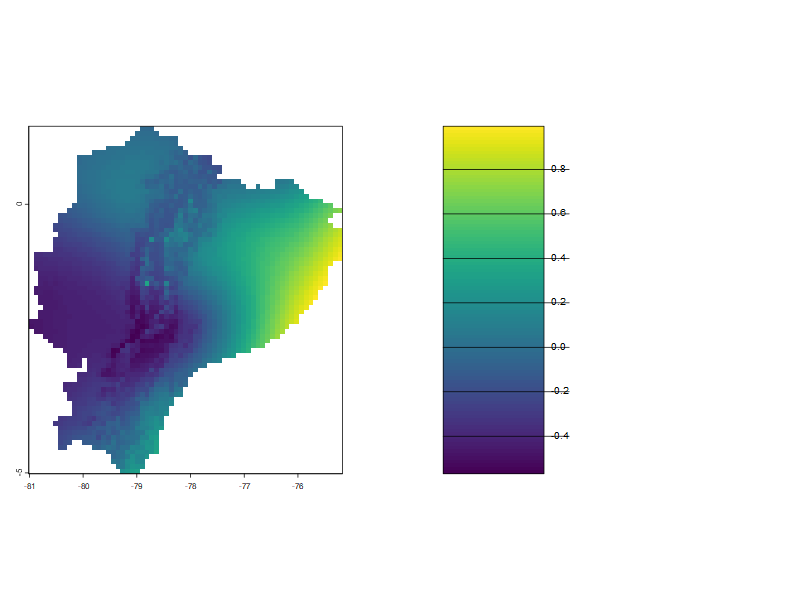

In [192]:

pred_vals <- predict(
  m_nmds2,
  newdata = df_pred,
  type = "response"   # identidad → predicción = η
)

df_pred$pred <- pred_vals


# =========================================================
# 6. Insertar predicciones en raster
# =========================================================

r_pred <- r10

cell_ids <- cellFromXY(r_pred, df_pred[, c("centroid_x", "centroid_y")])

vals <- rep(NA, ncell(r_pred))
vals[cell_ids] <- df_pred$pred

r_pred_nmds2 <- setValues(r_pred, vals)


# =========================================================
# 7. Máscara para limitar SOLO Ecuador
# =========================================================

r_pred_ecu_nmds2 <- mask(r_pred_nmds2, ecu_v)

plot(r_pred_ecu_nmds2)

# 5. Join  Bands

In [193]:
# Crear un stack con las dos capas NMDS1 y NMDS2
nmds_stack <- c(r_pred_ecu_nmds1, r_pred_ecu_nmds2)

nmds_stack

class       : SpatRaster 
dimensions  : 72, 65, 2  (nrow, ncol, nlyr)
resolution  : 0.08983112, 0.08983112  (x, y)
extent      : -81.01115, -75.17213, -5.016157, 1.451683  (xmin, xmax, ymin, ymax)
coord. ref. : lon/lat WGS 84 (EPSG:4326) 
source(s)   : memory
names       : NMDS1_pred, NMDS1_pred 
min values  : -1.3889654, -0.5688112 
max values  :  0.9640291,  0.9941628 

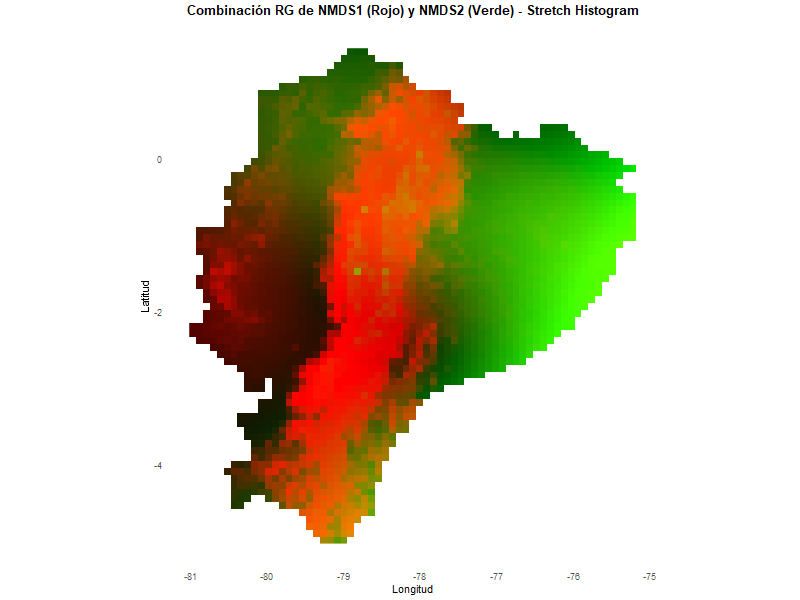

In [194]:


# Convertir de SpatRaster (terra) a RasterLayer (raster)
n1 <- raster(r_pred_ecu_nmds1)
n2 <- raster(r_pred_ecu_nmds2)

# Convertir a data frames con coordenadas
nmds_df1 <- as.data.frame(n1, xy = TRUE)
nmds_df2 <- as.data.frame(n2, xy = TRUE)

# Unir ambos data frames
df_nmds <- merge(nmds_df1, nmds_df2, by = c("x", "y"))
names(df_nmds) <- c("x", "y", "NMDS1", "NMDS2")

# Remover NAs
df_nmds <- na.omit(df_nmds)

# Stretch histogram - expande el contraste usando percentiles
hist_stretch <- function(x, percent = 0.02) {
  low <- quantile(x, percent, na.rm = TRUE)
  high <- quantile(x, 1 - percent, na.rm = TRUE)
  x[x < low] <- low
  x[x > high] <- high
  (x - low) / (high - low)
}

df_nmds$R <- hist_stretch(df_nmds$NMDS1)
df_nmds$G <- hist_stretch(df_nmds$NMDS2)

# Crear colores RGB
df_nmds$color <- rgb(df_nmds$R, df_nmds$G, 0)

# Plot con ggplot2
ggplot(df_nmds, aes(x = x, y = y)) +
  geom_raster(fill = df_nmds$color) +
  coord_equal() +
  labs(
    title = "Combinación RG de NMDS1 (Rojo) y NMDS2 (Verde) - Stretch Histogram",
    x = "Longitud",
    y = "Latitud"
  ) +
  theme_minimal() +
  theme(
    plot.title = element_text(hjust = 0.5, face = "bold"),
    panel.grid = element_blank()
  )

# 6. Clúster Analysis

## 6.1. Get NMDS dataframe

In [195]:
# Extraer los valores del stack de NMDS1 y NMDS2
nmds_values <- getValues(stack(nmds_stack))
nmds_values <- na.omit(nmds_values)
head(nmds_values)

     NMDS1_pred.1 NMDS1_pred.2
[1,]   -0.6619295  -0.03605063
[2,]   -0.6840906  -0.03685709
[3,]   -0.6869154  -0.03895315
[4,]   -0.6067372  -0.01817115
[5,]   -0.6154794  -0.01800072
[6,]   -0.6286162  -0.01861292

## 6.2. Clústers K means

*** : The Hubert index is a graphical method of determining the number of clusters.
                In the plot of Hubert index, we seek a significant knee that corresponds to a 
                significant increase of the value of the measure i.e the significant peak in Hubert
                index second differences plot. 
 
*** : The D index is a graphical method of determining the number of clusters. 
                In the plot of D index, we seek a significant knee (the significant peak in Dindex
                second differences plot) that corresponds to a significant increase of the value of
                the measure. 
 
******************************************************************* 
* Among all indices:                                                
* 3 proposed 2 as the best number of clusters 
* 15 proposed 3 as the best number of clusters 
* 1 proposed 8 as the best number of clusters 
* 3 proposed 9 as the best number of clusters 
* 1 proposed 10 as the best numbe

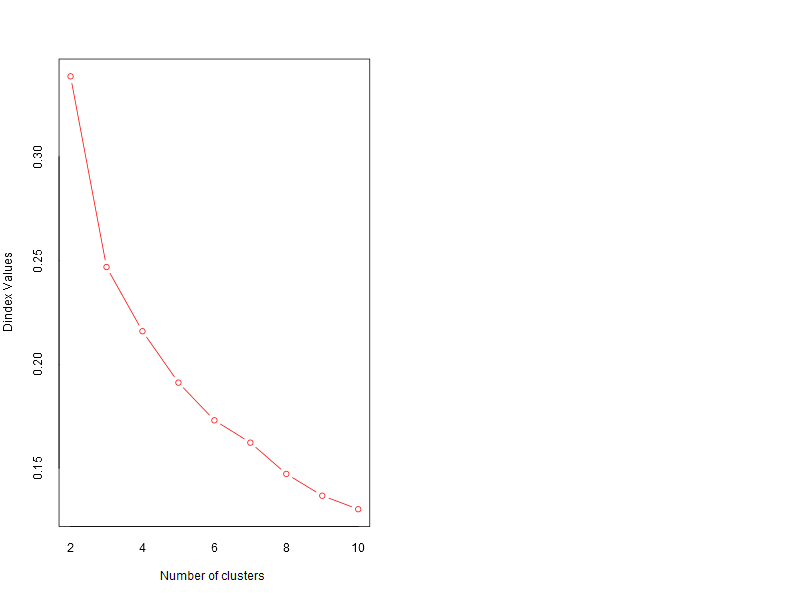

In [196]:

set.seed(593)
res_nb <- NbClust(nmds_values[, 1:2], distance = "euclidean",
                  min.nc = 2, max.nc = 10, method = "kmeans")

res_nb
     

## 6.3. Clúster Raster

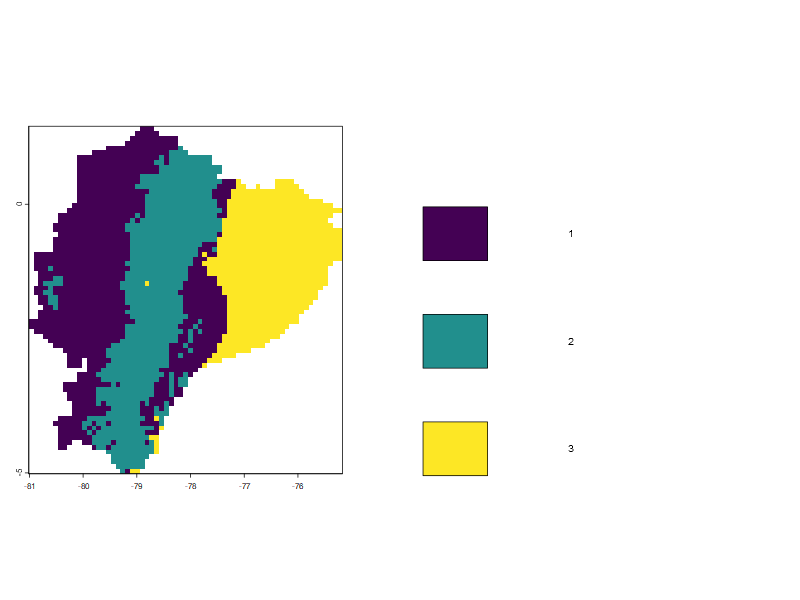

In [197]:

cluster_raster <- raster(stack(nmds_stack[[1]]))  # Usar la primera capa del stack para la plantilla
values(cluster_raster) <- NA  # Inicializar con NA
# Asignar los valores de los clusters al raster
cluster_raster[!is.na(getValues(stack(nmds_stack[[1]])))] <- res_nb$Best.partition
cluster_raster = rast(cluster_raster)
##plot cluster
plot(cluster_raster)

In [198]:
# Cargar tu stack NMDS como SpatRaster (ya lo tienes en nmds_stack)
# Crear raster de clusters como SpatRaster
cluster_raster <- rast(nmds_stack[[1]])
values(cluster_raster) <- NA

# Asignar la partición (vector res_nb$Best.partition) solo donde hay datos
vals <- values(nmds_stack[[1]])
cluster_raster[!is.na(vals)] <- res_nb$Best.partition

# Aplicar ventana focal 3x3 para obtener la moda
cluster_raster_clean <- focal(cluster_raster,
                    w = 3,
                    fun = modal,
                    na.policy = "omit",
                    na.rm = TRUE)

# Resultado final


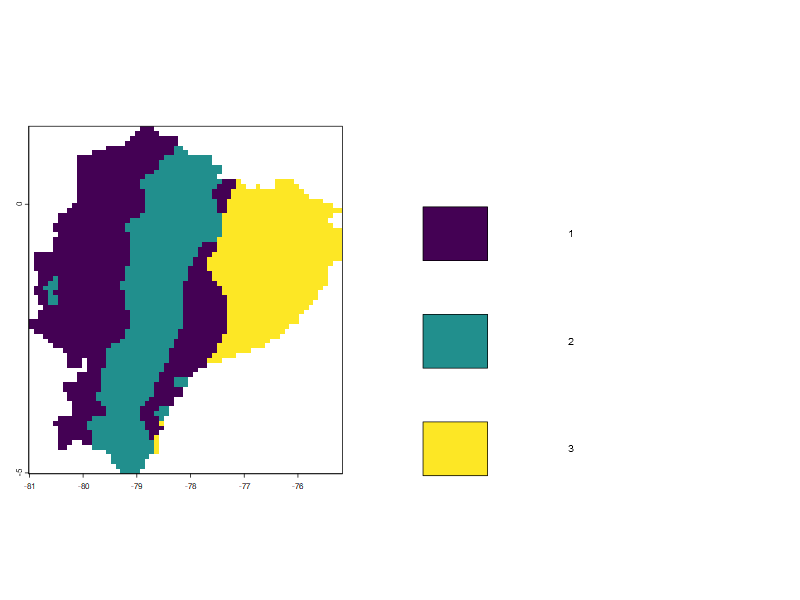

In [201]:
plot(cluster_raster_clean)

# 7. Export results

In [200]:
writeRaster(nmds_stack, "Results/raster/nmds_result.tiff", overwrite=TRUE)
writeRaster(cluster_raster_clean, "Results/raster/cluster_raster_result.tiff", overwrite=TRUE)